# Title

## Download data

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import hvplot.xarray
import cartopy
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10,10)
import fsspec
import gdrivefs
from skimage import measure

In [ ]:
! pip install fsspec==0.8.4
! pip install 'git+git://github.com/tjcrone/gdrivefs.git@540a55fae06cbed4f7d9f8d540ac29fcb640c38a'

In [3]:
gdfid = '1hzH32KcsdMtNX0f9_WkMTCyf20tj6ZLk'
gdfs = gdrivefs.GoogleDriveFileSystem(root_file_id = gdfid, token = 'browser')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=By3b1NIkFkza1RuNrCtG5sWVxZGKMB&prompt=consent&access_type=offline


Enter the authorization code:  4/1AY0e-g4BOIt7qjWIW_StJrkK7enQl-e3S4cIlwtl-iHh7Onm3uA6Bgel8dY


In [ ]:
files = gdfs.ls('/')
files

In [ ]:
ofs = []
for file in files: # only include NetCDF files in files
    ofs.append(gdfs.open(file))

ds = xr.open_mfdataset(ofs)
ds

Rechunking

In [7]:
ds = ds.chunk({'TIME': 1})

Create mapper

In [4]:
mapper = gdfs.get_mapper('ICE.2000-2010.zarr')

Save data to Zarr file on Google Drive

In [ ]:
ds.to_zarr(mapper)

Open data from Zarr file from Google Drive

In [5]:
# ds = xr.open_zarr(mapper, drop_variables={'AG', 'AG1', 'AL', 'AL1', 'COD', 'CP', 'CWP', 'CZ', 'FRA', 'FRV', 'G11', 'G21', 'IWP', 'LHF', 'LWD', 'LWU', 'ME', 'QI', 'QQ', 'QQP', 'QQZ', 'QR', 'QS', 'QW', 'RF', 'RH', 'RU2', 'RZ', 'SAL', 'SF', 'SHF', 'SHSN0', 'SHSN3', 'SLO', 'SMB', 'SOL', 'SP', 'SF', 'SRF', 'ST', 'ST2', 'SU', 'SW', 'SWD' 'TI1', 'TT', 'TTMAX', 'TTMIN', 'TTP', 'TTZ', 'UU', 'UUP', 'UUZ', 'UV', 'UVZ', 'VEG', 'VV', 'VVP', 'VVZ', 'WA1', 'WVP', 'ZN4', 'ZN5', 'ZN6', 'ZZ', 'ZZP'})
ds = xr.open_zarr(mapper)

In [ ]:
ds

## Dataprocessing

Only include cells where the ice fraction is larger than 50%

In [19]:
ds_MSK = ds.where(ds.MSK >= 50)
lat = ds.LAT[0,:,:]
lon = ds.LON[0,:,:]

Only include Greenland ice sheet, not Canada

In [20]:
blobs = ds.MSK[0,:,:] > 50
all_labels = measure.label(blobs)
GrIS_label = all_labels * 1.0
GrIS_label[GrIS_label == 0] = np.nan
GrIS_label[GrIS_label > 1] = np.nan

Define extent for map plots

In [21]:
extent = [-55,-25,58,84]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


ValueError: zero-size array to reduction operation minimum which has no identity

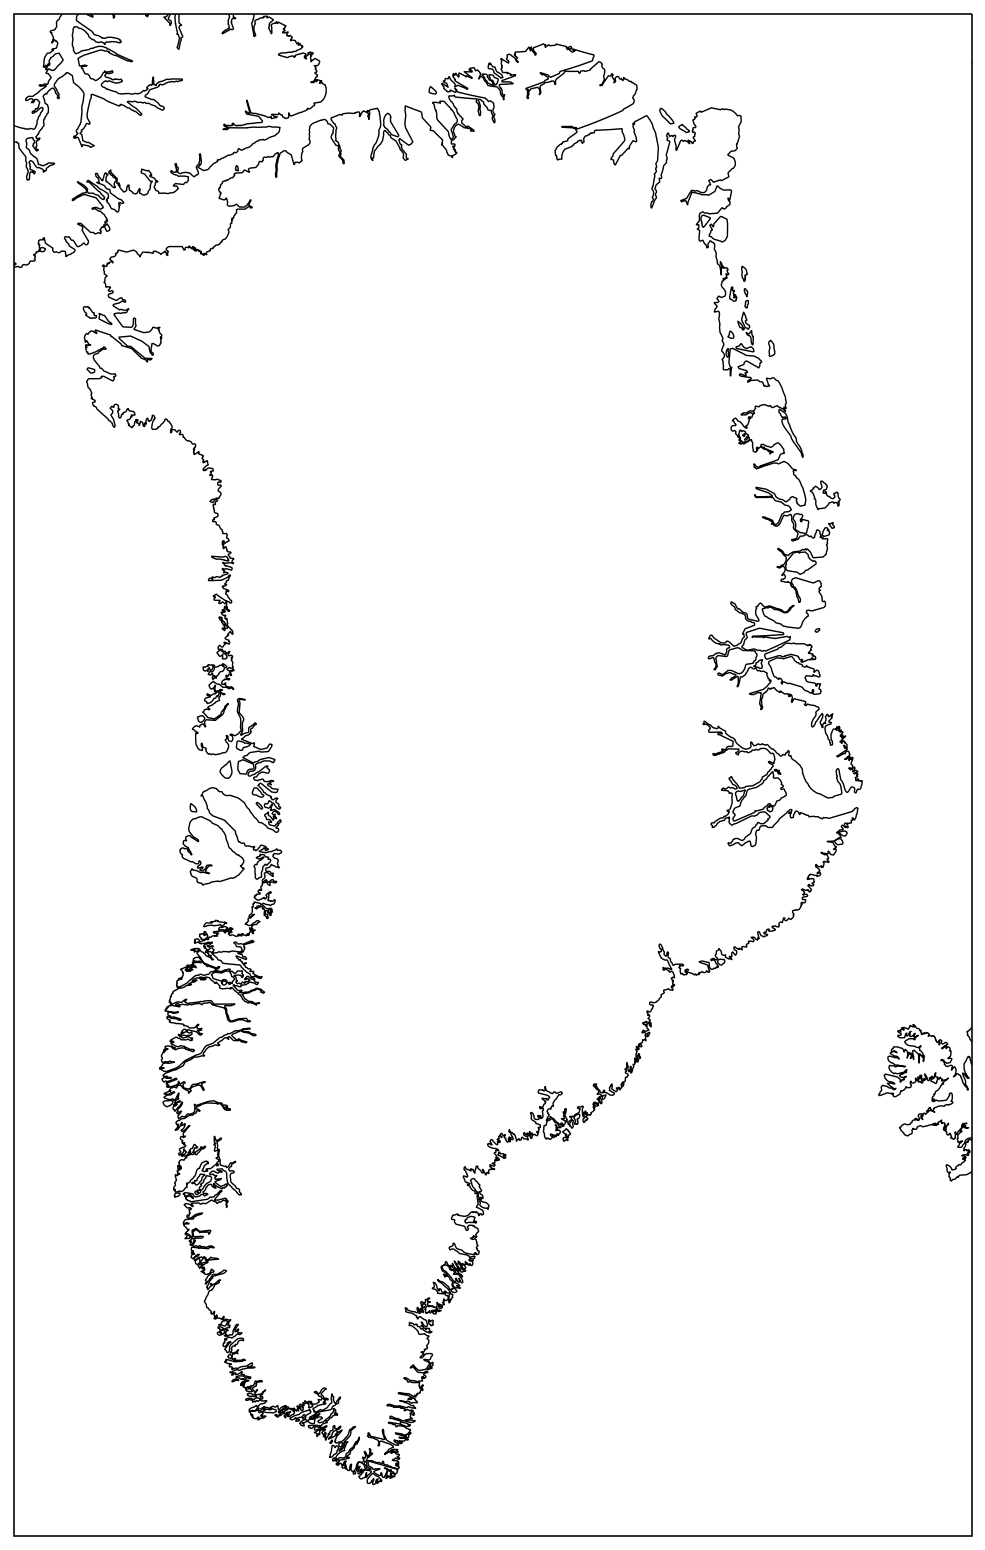

In [33]:
fig = plt.figure(figsize=(14,14))
ax = plt.axes(projection = ccrs.Orthographic(central_lon, central_lat))
ax.set_extent(extent)
ax.coastlines(resolution = '10m', linewidth=0.7)
c = ax.pcolor(lon, lat, ds_MSK.MSK[0,:,:] * GrIS_label, transform=ccrs.PlateCarree())
cbar = fig.colorbar(c, ax=ax, pad = 0.08)
cbar.set_label('Ice sheet area [%]', fontsize=20)
cbar.ax.tick_params(labelsize=14)

gl = ax.gridlines(draw_labels=True, linewidth=1, alpha=1)
gl.xlocator = mticker.FixedLocator([-60, -40, -20])
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylocator = mticker.FixedLocator([60, 70, 80])
gl.ylabel_style = {'size': 15, 'color': 'black'}
plt.title('Ice sheet area', weight='semibold', fontsize=20, pad=25);

In [34]:
ds_MSK.CC * GrIS_label

,Array,Chunk
Bytes,316.78 MB,78.84 kB
Shape,"(4018, 135, 73)","(1, 135, 73)"
Count,20093 Tasks,4018 Chunks
Type,float64,numpy.ndarray


In [35]:
ds_MSK_y = ds_MSK.TIME.groupby('TIME.year')
ds_MSK_y

DataArrayGroupBy, grouped over 'year' 
11 groups with labels 2000, 2001, 2002, ..., 2009, 2010.

In [36]:
# Annual means
fig = plt.figure(figsize=(14,14))
(ds_MSK.CC * GrIS_label).groupby('TIME.year').mean(dim=['TIME','Y21_155', 'X12_84']).hvplot()
# (ds_MSK.CU * GrIS_label).groupby('TIME.year').mean(dim=['TIME','Y21_155', 'X12_84']).hvplot()

OSError: [Errno 0] Error

<Figure size 1008x1008 with 0 Axes>

In [259]:
ds_MSK.CC.groupby('TIME.day').mean(dim=['TIME','Y21_155', 'X12_84']).hvplot()


:Curve   [day]   (CC)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


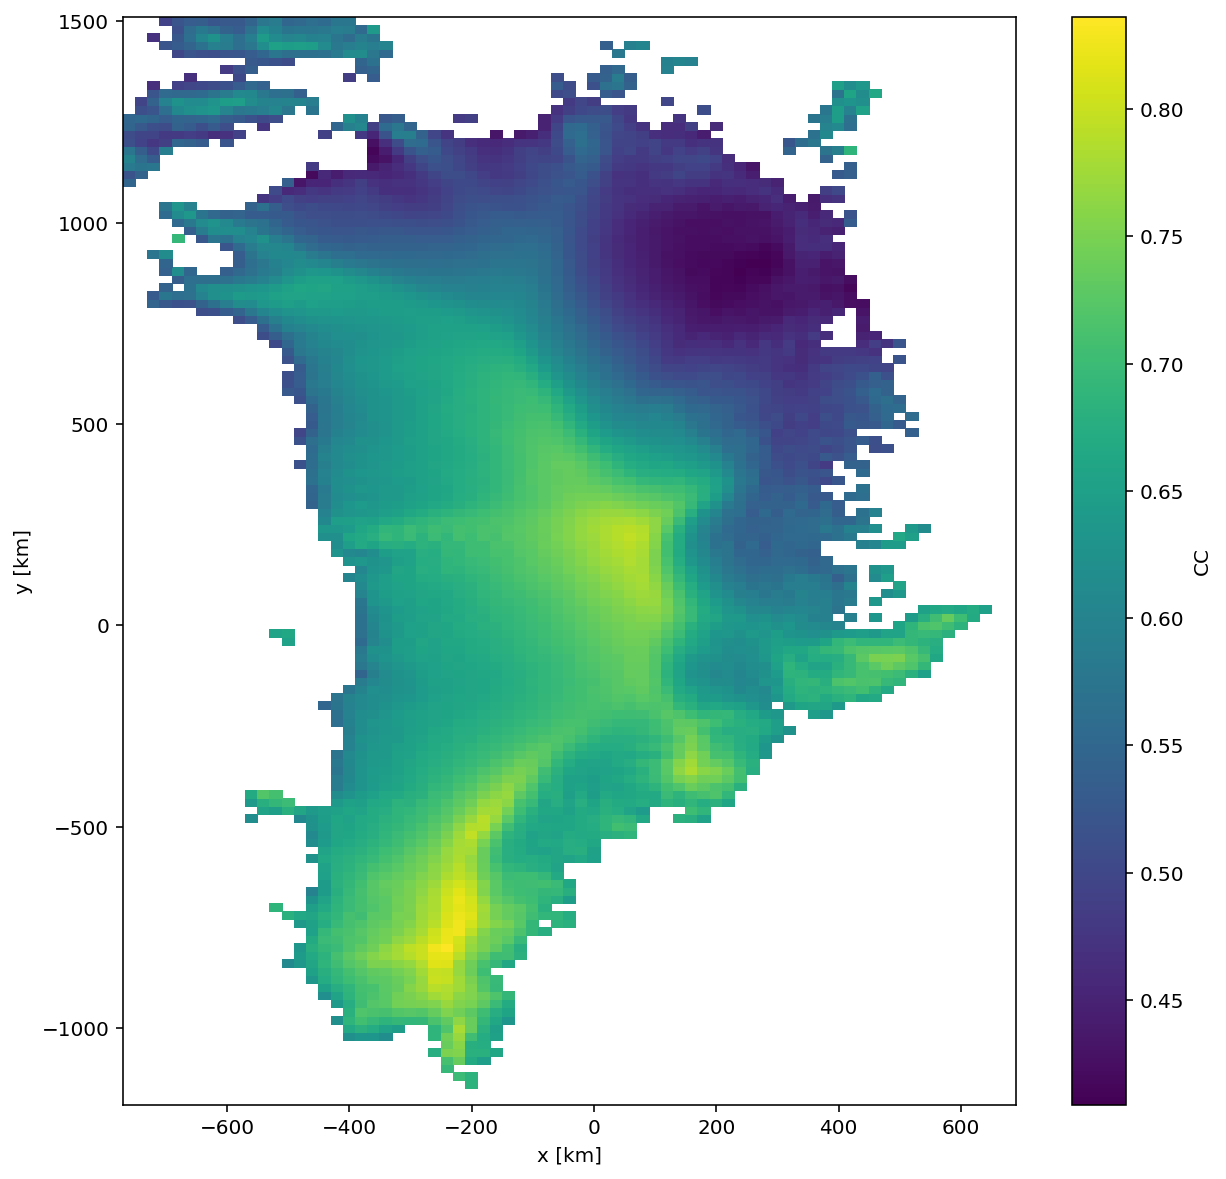

In [230]:
# subplots of upper, middle, lower cloud content

ds_MSK.CU.mean(dim='TIME').plot();

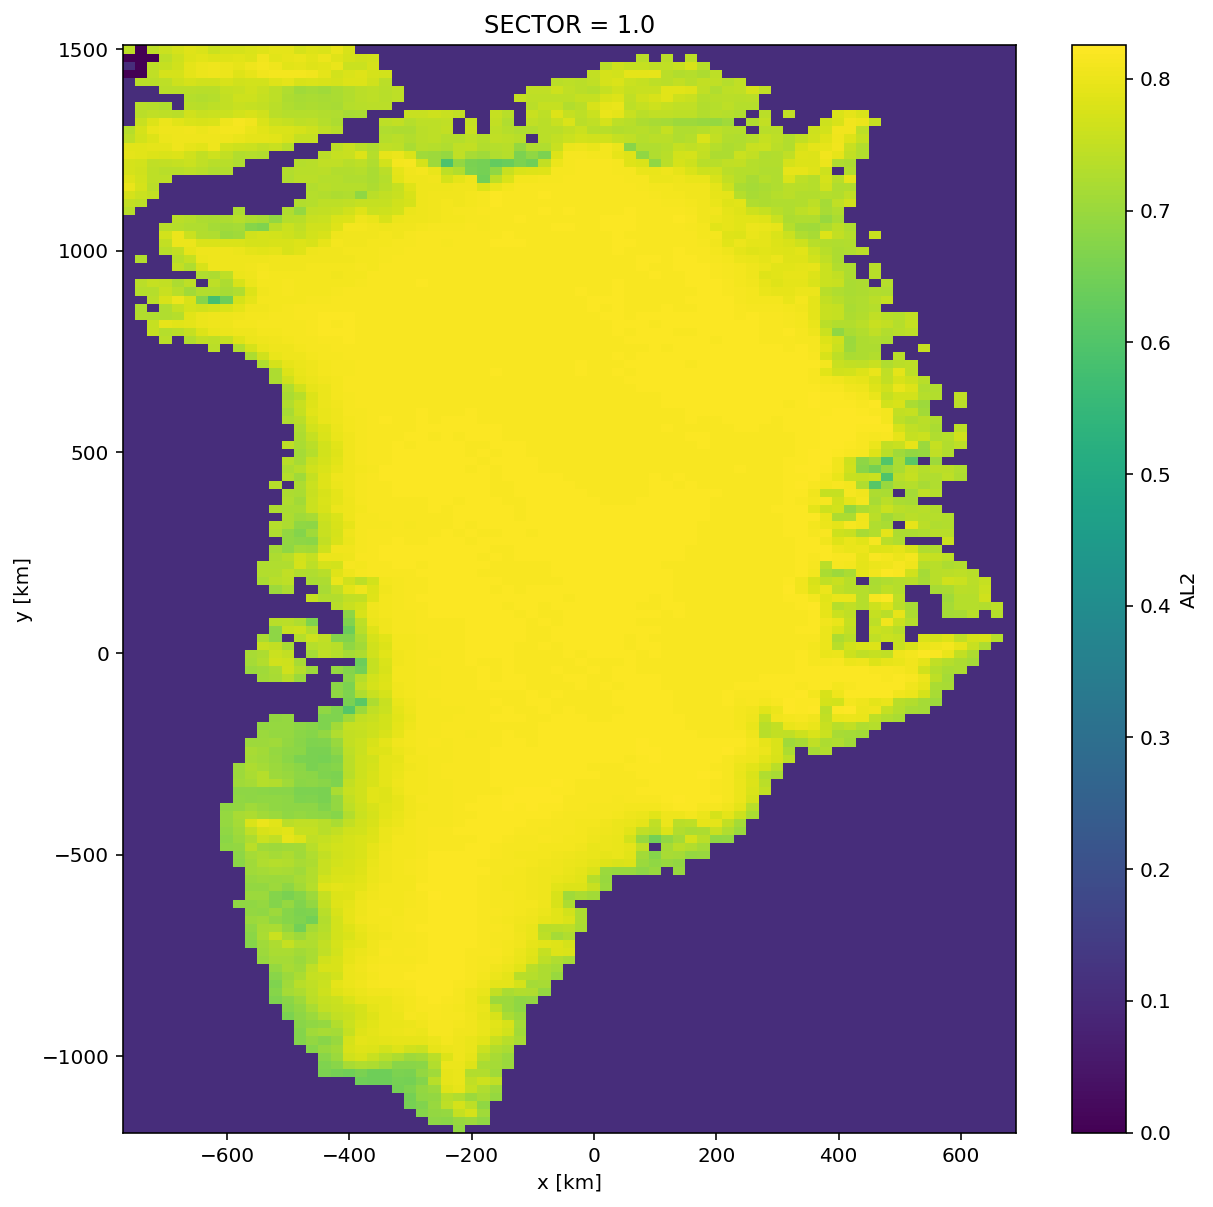

In [46]:
ds.AL2[:,0,:,:].mean(dim='TIME').plot();